# 01 — Data Collection

Pulls and saves all raw inputs for the Commercial Viability Index:
- Census tract boundaries (Suffolk County, clipped to Boston)
- ACS demographics — income, population, age 25–54
- MBTA stop locations (bus + rapid transit)
- Commercial POIs from OSM

All outputs go to `../data/raw/`.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import requests
import io
import zipfile
import warnings
from pathlib import Path

import pygris
from pygris.data import get_census

warnings.filterwarnings('ignore')

RAW_DIR = Path('../data/raw')
RAW_DIR.mkdir(parents=True, exist_ok=True)

# Confirm where files will land
print(RAW_DIR.resolve())

/Users/administrator/Documents/data/raw


## 1. Census tract boundaries

Pulling 2020 TIGER/Line tracts for Suffolk County (FIPS 25025), then filtering to tracts whose centroid falls inside the Boston city boundary. Centroid-based filter avoids splitting edge tracts.

In [2]:
tracts = pygris.tracts(state='MA', county='Suffolk', year=2020, cb=True)
tracts = tracts.to_crs(epsg=4326)
print(f'Suffolk tracts: {len(tracts)}')

Using FIPS code '25' for input 'MA'
Using FIPS code '025' for input 'Suffolk'
Suffolk tracts: 234


In [3]:
boston_boundary = ox.geocode_to_gdf('Boston, Massachusetts, USA').to_crs(epsg=4326)

tracts['centroid'] = tracts.geometry.centroid
mask = tracts.set_geometry('centroid').within(boston_boundary.geometry.iloc[0])
boston_tracts = tracts[mask].set_geometry('geometry').drop(columns='centroid').copy()
boston_tracts['GEOID'] = boston_tracts['GEOID'].astype(str).str.zfill(11)

print(f'Boston tracts: {len(boston_tracts)}')
boston_tracts.to_file(RAW_DIR / 'boston_tracts.gpkg', driver='GPKG')

Boston tracts: 205


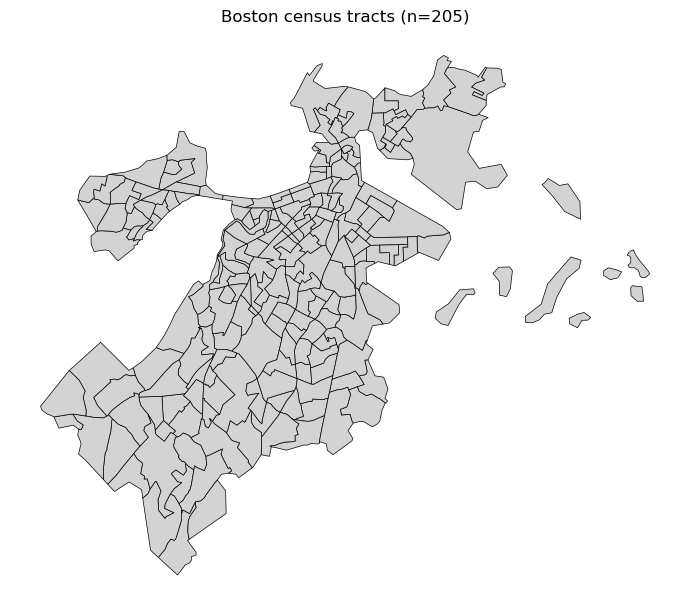

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 7))
boston_tracts.plot(ax=ax, edgecolor='black', linewidth=0.5, facecolor='lightgrey')
ax.set_title(f'Boston census tracts (n={len(boston_tracts)})')
ax.set_axis_off()
plt.tight_layout()
plt.savefig(RAW_DIR / 'check_tracts.png', dpi=150)
plt.show()

## 2. ACS demographics

Three variables from ACS 2022 5-year estimates at tract level:
- Median household income — spending power proxy
- Total population — market size
- Population aged 25–54 — peak commercial spending cohort

Age 25–54 requires summing 8 sub-group variables (male + female bands).

In [5]:
VARIABLES = [
    'B19013_001E',  # median HH income
    'B01003_001E',  # total population
    'B01001_011E', 'B01001_012E', 'B01001_013E', 'B01001_014E',  # male 25-54
    'B01001_035E', 'B01001_036E', 'B01001_037E', 'B01001_038E',  # female 25-54
]

acs_raw = get_census(
    dataset='acs/acs5',
    year=2022,
    variables=VARIABLES,
    params={'for': 'tract:*', 'in': 'state:25 county:025'}
)

print(f'Tracts returned: {len(acs_raw)}')
acs_raw.head(3)

Tracts returned: 235


,B19013_001E,B01003_001E,B01001_011E,B01001_012E,B01001_013E,B01001_014E,B01001_035E,B01001_036E,B01001_037E,B01001_038E,state,county,tract
0,135156,1734,257,63,67,18,204,86,86,94,25,025,000101
1,84044,3979,510,43,163,26,421,541,120,45,25,025,000102
2,111477,4375,570,314,323,99,499,276,178,247,25,025,000201


In [6]:
acs = acs_raw.copy()
acs['GEOID'] = (acs['state'] + acs['county'] + acs['tract']).str.zfill(11)

acs = acs.rename(columns={
    'B19013_001E': 'median_hh_income',
    'B01003_001E': 'total_population'
})

num_cols = [c for c in acs.columns if c not in ['state', 'county', 'tract', 'GEOID']]
acs[num_cols] = acs[num_cols].apply(pd.to_numeric, errors='coerce')
acs = acs.replace(-666666666, np.nan)

age_cols = [
    'B01001_011E', 'B01001_012E', 'B01001_013E', 'B01001_014E',
    'B01001_035E', 'B01001_036E', 'B01001_037E', 'B01001_038E'
]
acs['pop_25_54'] = acs[age_cols].sum(axis=1)
acs['share_25_54'] = acs['pop_25_54'] / acs['total_population']

acs_clean = acs[['GEOID', 'median_hh_income', 'total_population', 'pop_25_54', 'share_25_54']]

print(f'Null income: {acs_clean.median_hh_income.isna().sum()}')
acs_clean.to_csv(RAW_DIR / 'acs_demographics.csv', index=False)
acs_clean.describe()

Null income: 17


,median_hh_income,total_population,pop_25_54,share_25_54
count,218.000000,235.000000,235.000000,227.000000
mean,94534.330275,3342.310638,1207.485106,0.380411
std,46005.917602,1725.348661,670.900583,0.140299
min,18125.000000,0.000000,0.000000,0.000000
25%,63666.500000,2288.500000,758.500000,0.287483
50%,84873.500000,3230.000000,1156.000000,0.357666
75%,118125.000000,4402.000000,1633.000000,0.450974
max,245000.000000,9131.000000,2972.000000,1.000000


## 3. MBTA stops

Pulling from the MBTA's public GTFS static feed. Keeping bus (route_type 3) and rapid transit (0, 1) — both matter for commercial accessibility. Where a stop serves multiple modes, I keep the most rapid service type.

In [7]:
print('Downloading MBTA GTFS...')
response = requests.get('https://cdn.mbta.com/MBTA_GTFS.zip', stream=True)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    stops = pd.read_csv(z.open('stops.txt'))
    routes = pd.read_csv(z.open('routes.txt'))
    trips = pd.read_csv(z.open('trips.txt'))
    stop_times = pd.read_csv(z.open('stop_times.txt'), usecols=['trip_id', 'stop_id'])

print(f'Stops: {len(stops)} | Routes: {len(routes)}')

Stops: 10244 | Routes: 399


In [8]:
relevant_routes = routes[routes['route_type'].isin([0, 1, 3])][['route_id', 'route_type']]
trips_typed = trips[['trip_id', 'route_id']].merge(relevant_routes, on='route_id')
stop_routes = stop_times.merge(trips_typed, on='trip_id')[['stop_id', 'route_type']].drop_duplicates()

# Best (most rapid) mode per stop — lower route_type = more rapid
stop_best = stop_routes.groupby('stop_id')['route_type'].min().reset_index()
stop_best.columns = ['stop_id', 'best_route_type']

stops_filtered = stops.merge(stop_best, on='stop_id').dropna(subset=['stop_lat', 'stop_lon'])
stops_filtered['transit_mode'] = stops_filtered['best_route_type'].map({
    0: 'light_rail', 1: 'subway', 3: 'bus'
})

stops_gdf = gpd.GeoDataFrame(
    stops_filtered[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'transit_mode']],
    geometry=gpd.points_from_xy(stops_filtered['stop_lon'], stops_filtered['stop_lat']),
    crs='EPSG:4326'
)

stops_boston = stops_gdf[stops_gdf.within(boston_boundary.geometry.iloc[0])].copy()
print(stops_boston['transit_mode'].value_counts())

stops_boston.to_file(RAW_DIR / 'mbta_stops_boston.gpkg', driver='GPKG')

transit_mode
bus           213
light_rail     87
subway         73
Name: count, dtype: int64


## 4. Commercial POIs

Pulling from OSM via OSMnx. Keeping retail, food & beverage, services, and office — anything that signals commercial activity or generates foot traffic. Polygons converted to centroids for consistent point-in-polygon joins later.

In [9]:
print('Fetching POIs from OSM...')
pois_raw = ox.features_from_place(
    'Boston, Massachusetts, USA',
    tags={
        'shop': True,
        'amenity': ['restaurant', 'cafe', 'bar', 'fast_food', 'bank', 'pharmacy', 'clinic'],
        'office': True
    }
)
print(f'Raw features: {len(pois_raw)}')

Fetching POIs from OSM...
Raw features: 3849


In [10]:
pois = pois_raw.to_crs(epsg=4326).copy()
pois['geometry'] = pois.geometry.centroid

keep = ['geometry'] + [c for c in ['shop', 'amenity', 'office', 'name'] if c in pois.columns]
pois = pois[keep].copy()

def classify_poi(row):
    if pd.notna(row.get('shop')) and row.get('shop') not in [False, 'no']:
        return 'retail'
    amenity = row.get('amenity', '')
    if amenity in ['restaurant', 'cafe', 'bar', 'fast_food']:
        return 'food_beverage'
    if amenity in ['bank', 'clinic', 'pharmacy']:
        return 'services'
    if pd.notna(row.get('office')) and row.get('office') not in [False, 'no']:
        return 'office'
    return 'other'

pois['poi_type'] = pois.apply(classify_poi, axis=1)

pois_boston = pois[pois.within(boston_boundary.geometry.iloc[0])].reset_index(drop=True)
print(pois_boston['poi_type'].value_counts())

pois_boston.to_file(RAW_DIR / 'boston_pois.gpkg', driver='GPKG')

poi_type
food_beverage    1597
retail           1557
office            477
services          216
Name: count, dtype: int64


## 5. Sanity check

In [11]:
files = ['boston_tracts.gpkg', 'acs_demographics.csv', 'mbta_stops_boston.gpkg', 'boston_pois.gpkg']

for f in files:
    p = RAW_DIR / f
    size = f'{p.stat().st_size / 1024:.0f} KB' if p.exists() else 'MISSING'
    print(f'  {"OK" if p.exists() else "!!"}  {f:<40} {size}')

  OK  boston_tracts.gpkg                       224 KB
  OK  acs_demographics.csv                     11 KB
  OK  mbta_stops_boston.gpkg                   152 KB
  OK  boston_pois.gpkg                         580 KB


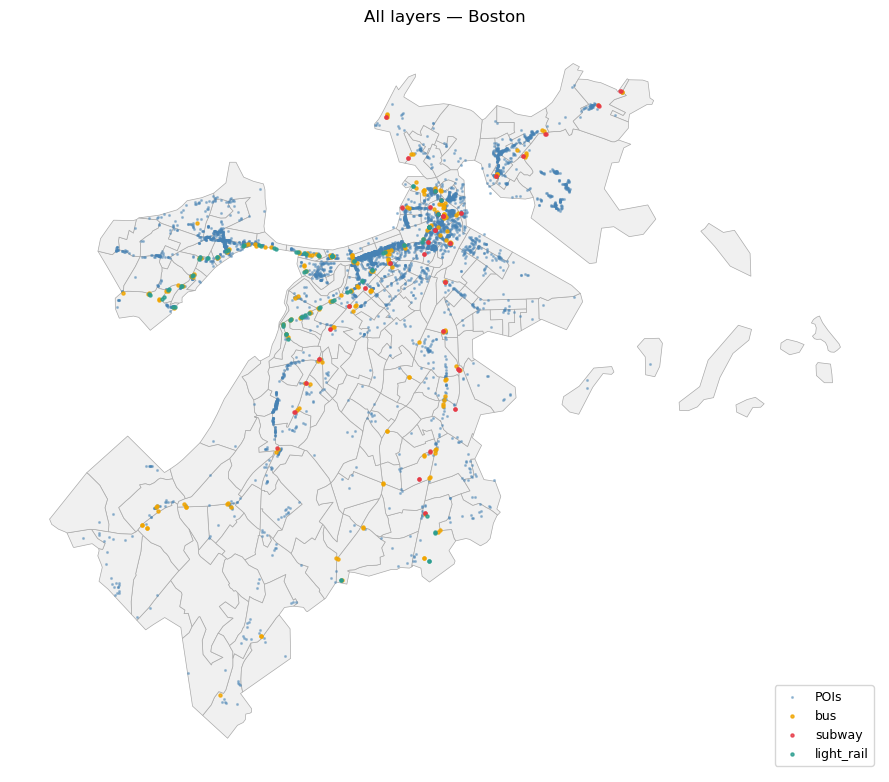

In [12]:
fig, ax = plt.subplots(figsize=(9, 9))
boston_tracts.plot(ax=ax, facecolor='#f0f0f0', edgecolor='#aaaaaa', linewidth=0.5, zorder=1)
pois_boston.plot(ax=ax, color='steelblue', markersize=1.5, alpha=0.4, zorder=2, label='POIs')

colours = {'bus': '#f0a500', 'subway': '#e63946', 'light_rail': '#2a9d8f'}
for mode, colour in colours.items():
    s = stops_boston[stops_boston['transit_mode'] == mode]
    if len(s):
        s.plot(ax=ax, color=colour, markersize=5, alpha=0.8, zorder=3, label=mode)

ax.legend(loc='lower right', fontsize=9)
ax.set_title('All layers — Boston')
ax.set_axis_off()
plt.tight_layout()
plt.savefig(RAW_DIR / 'check_all_layers.png', dpi=150, bbox_inches='tight')
plt.show()